In [2]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm.auto import tqdm

%load_ext lab_black
%load_ext watermark

# 7. Metropolis: Normal-Cauchy*

Adapted from [Unit 5: norcaumet.m](https://raw.githubusercontent.com/areding/6420-pymc/main/original_examples/Codes4Unit5/norcaumet.m).

For this example:

$$
\begin{align}
X \mid \theta &\sim N(\theta, 1) \\
\theta &\sim \text{{Cauchy}}(0, 1)
\end{align}
$$

## Original method

The professor chooses a N(x_j, 1) proposal. This is an independent proposal, plus it simplifies the acceptance ratio quite a bit. Here's how we get the ratio:

$$
\begin{align}
\pi(\theta\mid X) &\propto f(x|\theta)\pi(\theta) \\
&\propto \frac{e^{-\frac{(x - \theta)^2}{2}}}{1+\theta^2}
\end{align}
$$

$$
\begin{align}
\rho &= \frac{\pi(\theta')q(\theta\mid\theta')}{\pi(\theta)q(\theta'\mid\theta)} \\
&= \frac{\frac{e^{-\frac{(x - \theta')^2}{2}}}{1+{\theta'}^2}e^{-\frac{(\theta - x)^2}{2}}}{\frac{e^{-\frac{(x - \theta)^2}{2}}}{1+\theta^2}e^{-\frac{(\theta' - x)^2}{2}}}
&= \frac{1 + \theta^2}{1 + {\theta'}^2}
\end{align}
$$

Skipping some intermediate steps for now, but if you'd like to see them let me know and I'll take some time to add them.

```{warning}
I usually pre-generate arrays of random numbers (see ```theta_prop``` and ```unif``` variables in the below cell) because it's computationally faster. However, that only works when those numbers don't depend on the previous step in the sampling loop!
```

  0%|          | 0/1000000 [00:00<?, ?it/s]

np.mean(thetas)=1.283
np.var(thetas)=0.863
np.sum(accepted)/n=0.588


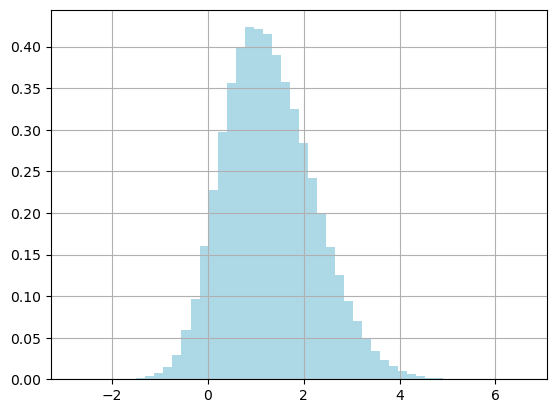

In [9]:
rng = np.random.default_rng(1)

n = 1000000  # observations
burn = 500
theta = 1  # init
thetas = np.zeros(n)
x = 2  # observed

accepted = np.zeros(n)

# generating necessary randoms as arrays is faster
theta_prop = rng.standard_normal(n) + x
unif = rng.uniform(size=n)

for i in tqdm(range(n)):
    r = (1 + theta**2) / (1 + theta_prop[i] ** 2)
    rho = min(r, 1)
    if unif[i] < rho:
        theta = theta_prop[i]
        accepted[i] = 1
    thetas[i] = theta

thetas = thetas[burn:]

print(f"{np.mean(thetas)=:.3f}")
print(f"{np.var(thetas)=:.3f}")
print(f"{np.sum(accepted)/n=:.3f}")

fig, ax = plt.subplots()
ax.grid(True)
plt.hist(thetas, color="lightblue", density=True, bins=50)
plt.show()

## Non-centered proposal

Someone asked how we would do this without centering the proposal on the current x value. Here's what that looks like.

  0%|          | 0/1000000 [00:00<?, ?it/s]

np.mean(thetas)=1.277
np.var(thetas)=0.859
np.sum(accepted)/n=0.350


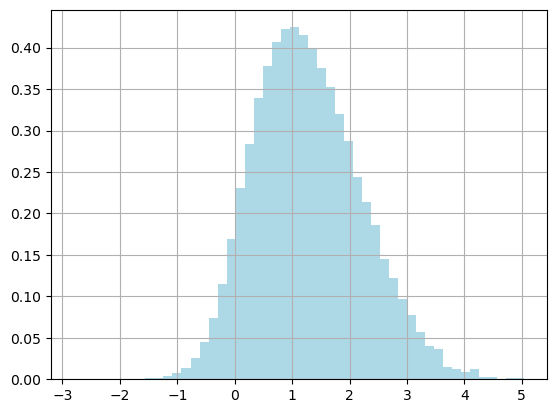

In [13]:
n = 1000000
burn = 500
theta = 1
thetas = np.zeros(n)
x = 2

accepted = np.zeros(n)

theta_prop = rng.standard_normal(n)
unif = rng.uniform(size=n)


def q(theta, x):
    return np.exp(-0.5 * (x) ** 2)


def f(x, theta):
    return np.exp(-0.5 * (x - theta) ** 2) / (1 + theta**2)


for i in tqdm(range(n)):
    r = (f(x, theta_prop[i]) / f(x, theta)) * (q(x, theta)) / q(x, theta_prop[i])
    rho = min(r, 1)
    if unif[i] < rho:
        theta = theta_prop[i]
        accepted[i] = 1
    thetas[i] = theta

thetas = thetas[burn:]

print(f"{np.mean(thetas)=:.3f}")
print(f"{np.var(thetas)=:.3f}")
print(f"{np.sum(accepted)/n=:.3f}")

fig, ax = plt.subplots()
ax.grid(True)
plt.hist(thetas, color="lightblue", density=True, bins=50)
plt.show()

The end results are very close. But the acceptance rate is much lower!

In [14]:
%watermark -n -u -v -iv

Last updated: Fri Aug 04 2023

Python implementation: CPython
Python version       : 3.11.0
IPython version      : 8.9.0

numpy     : 1.24.2
matplotlib: 3.6.3

